In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from skimage.draw import ellipse
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from skimage import measure
from DataManager import DataManager
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from utils import reshape_insole_grid,segment_insole_data,calculate_peak_impulse,calculate_region_impulse,calculate_relative_region_impulse, plot_insole_grid, anova_test

# Andrew

In [2]:
with open('data/080624_seg_coords.pkl', 'rb') as file:
    coords = pickle.load(file)

In [3]:
coords[0]

{'filename': 'gait_recording_080624_walk.mat',
 'height_valleys_l': [12, 31],
 'width_valleys_l': [7, 10],
 'height_valleys_r': [12, 32],
 'width_valleys_r': [8, 4]}

In [ ]:
data = sio.loadmat(f'data/GAIT080624-01/gait_recording_080624_walk1.mat')

insoleAll_l = data['insoleAll_l'].astype(np.float64)
insoleAll_r = data['insoleAll_r'].astype(np.float64)

insole_l = insoleAll_l.reshape((-1, 64, 16), order="F")
insole_r = insoleAll_r.reshape((-1, 64, 16), order="F")

# need to flip the top half of the heatmap up-down
insole_l[:, :32, :] = np.flip(insole_l[:, :32, :], axis=1)
insole_r[:, :32, :] = np.flip(insole_r[:, :32, :], axis=1)

# insole_spatial_r = np.flip(insole_r, axis=2)

t_insole_l = data['t_insole_l'].astype(np.float64)
t_insole_r = data['t_insole_r'].astype(np.float64)

height_seg_cords_l = [12, 31]
width_seg_cords_l = [[7], [10], []]

height_seg_cords_r = [12, 32]
width_seg_cords_r = [[8], [12], []]

# resample_frames = 500

mapping_dict = {'(0-12,0-7)':1, '(0-12,7-16)':2, '(12-31,0-10)':3, '(12-31,10-16)':4,
       '(31-64,0-16)':5, '(0-12,0-8)':1, '(0-12,8-16)':2, '(12-32,0-12)':3,
       '(12-32,12-16)':4, '(32-64,0-16)':5}

In [5]:
insole_data = insoleAll_l

# Resampling Frames based on Walking Cycle
split_idx_df = pd.read_csv('data/strikeandoffindices.csv')
cycle_idx = split_idx_df['080624_walkstrike_l'].dropna()
cycle_number = 10
start_idx = [cycle_idx[i] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]
end_idx = [cycle_idx[i+cycle_number] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]

final_df = pd.DataFrame()

for i,_ in tqdm(enumerate(start_idx)):
    
    input_insole = insole_data[int(start_idx[i]):int(end_idx[i])]
    if input_insole.shape[0] == 0:
        continue

    segmented_dict = segment_insole_data(input_insole, height_seg_cords_l, width_seg_cords_l)
    output_df = calculate_relative_region_impulse(segmented_dict)
    output_df['Peak Pressure'] = output_df['Region'].apply(lambda x: calculate_peak_impulse(segmented_dict[x]))
    output_df = output_df[['Region','Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']]
    output_df['sample_idx'] = i
    output_df['foot'] = 'left'
    final_df = pd.concat([final_df, output_df], axis = 0, ignore_index=True)


insole_data = insoleAll_r

cycle_idx = split_idx_df['080624_walkstrike_r'].dropna()
cycle_number = 10
start_idx = [cycle_idx[i] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]
end_idx = [cycle_idx[i+cycle_number] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]

for i,_ in tqdm(enumerate(start_idx)):
    
    input_insole = insole_data[int(start_idx[i]):int(end_idx[i])]
    if input_insole.shape[0] == 0:
        continue
    
    segmented_dict = segment_insole_data(input_insole, height_seg_cords_r, width_seg_cords_r)
    output_df = calculate_relative_region_impulse(segmented_dict)
    output_df['Peak Pressure'] = output_df['Region'].apply(lambda x: calculate_peak_impulse(segmented_dict[x]))
    output_df = output_df[['Region','Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']]
    output_df['sample_idx'] = i
    output_df['foot'] = 'right'
    final_df = pd.concat([final_df, output_df], axis = 0, ignore_index=True)

final_df['region index'] = final_df['Region'].apply(lambda x : x.split('|')[1])
final_df['Region'] = final_df['Region'].apply(lambda x : x.split('|')[0])
final_df.to_excel('data/left_right_comparison.xlsx',index = False)

11it [00:00, 58.29it/s]
11it [00:00, 72.48it/s]


In [32]:
segmented_dict = segment_insole_data(input_insole, height_seg_cords_r, width_seg_cords_r)
section_data = segmented_dict['(0-12,0-8) | 1']
sum_array = section_data.sum(axis = 0)
activation_threshold = 0.05 * np.max(sum_array)
activation_masks = sum_array >= activation_threshold
section_data = section_data[:,activation_masks]

total_impulse = np.sum(section_data, axis = 1)
total_impulse = total_impulse/activation_masks.sum()

Text(0, 0.5, 'Pressure')

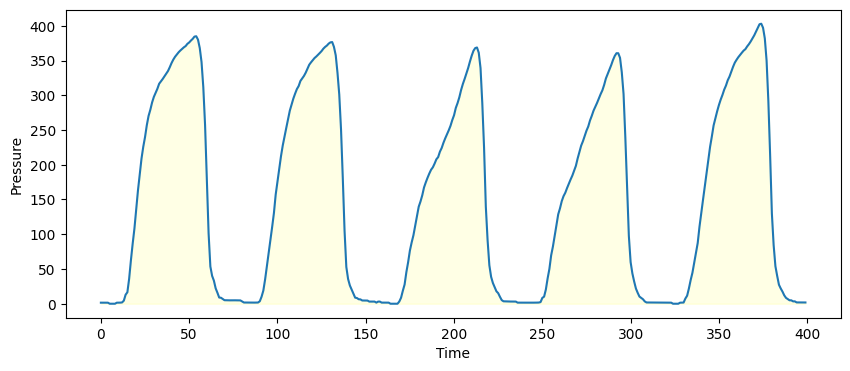

In [33]:
fig = plt.figure(figsize=(10,4))
total_impulse_plot = total_impulse[50:450]
plt.plot(total_impulse_plot)
plt.fill_between(range(len(total_impulse_plot)), total_impulse_plot, alpha=0.1,color='yellow')
plt.xlabel('Time')
plt.ylabel('Pressure')

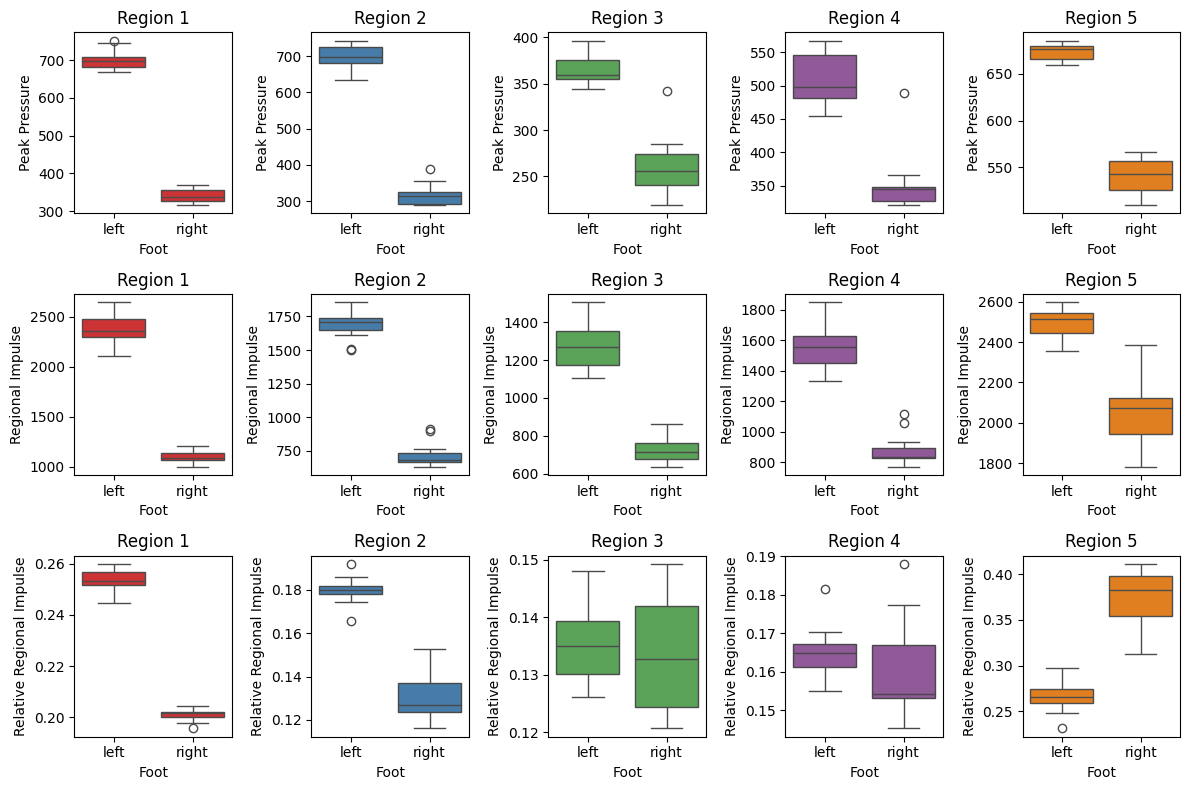

In [7]:
df = final_df
variables = ["Peak Pressure", "Regional Impulse", "Relative Regional Impulse"]
region_indices = sorted(df["region index"].dropna().unique())
palette = dict(zip(range(5), sns.color_palette("Set1", len(region_indices))))  # Using 'viridis' colormap


# Create subplots with 3 rows (variables) and 5 columns (region indices)
fig, axes = plt.subplots(len(variables), len(region_indices), figsize=(12, 8))

# Generate box plots
for j, var in enumerate(variables):
    for i, region in enumerate(region_indices):
        ax = axes[j, i]
        sns.boxplot(
            data=df[df["region index"] == region],
            x="foot",
            y=var,
            ax=ax,
            color=palette[i]
        )
        ax.set_title(f"Region {int(region)}")
        ax.set_xlabel("Foot")
        ax.set_ylabel(var)

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [57]:
palette

{' 1': (0.267968, 0.223549, 0.512008),
 ' 2': (0.190631, 0.407061, 0.556089),
 ' 3': (0.127568, 0.566949, 0.550556),
 ' 4': (0.20803, 0.718701, 0.472873),
 ' 5': (0.565498, 0.84243, 0.262877)}

In [35]:
from scipy import stats
def anova_test(df, cat = None, num = None):
    categories = df[cat].unique()
    groups = [df[df[cat]==name][num] for name in categories]
    f_stat, p_value = stats.f_oneway(*groups)
    return pd.DataFrame({'F-statistics': f_stat,'p-value':p_value}, index = [0])

In [36]:
test_variables = ['Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']

test_df = pd.DataFrame()
for region, region_df in final_df.groupby('region index'):
    for var in test_variables:
        test_result = anova_test(region_df, cat = 'foot',num=var)
        test_result['region index'] = region
        test_result['Target Variable'] = var
        test_df = pd.concat([test_df, test_result], axis = 0, ignore_index=True)

test_df = test_df[['region index', 'Target Variable', 'F-statistics', 'p-value']]
test_df.to_excel('left_right_asymmetry_test.xlsx')

In [37]:
test_df.to_excel('data/left_right_anova_test.xlsx', index = False)

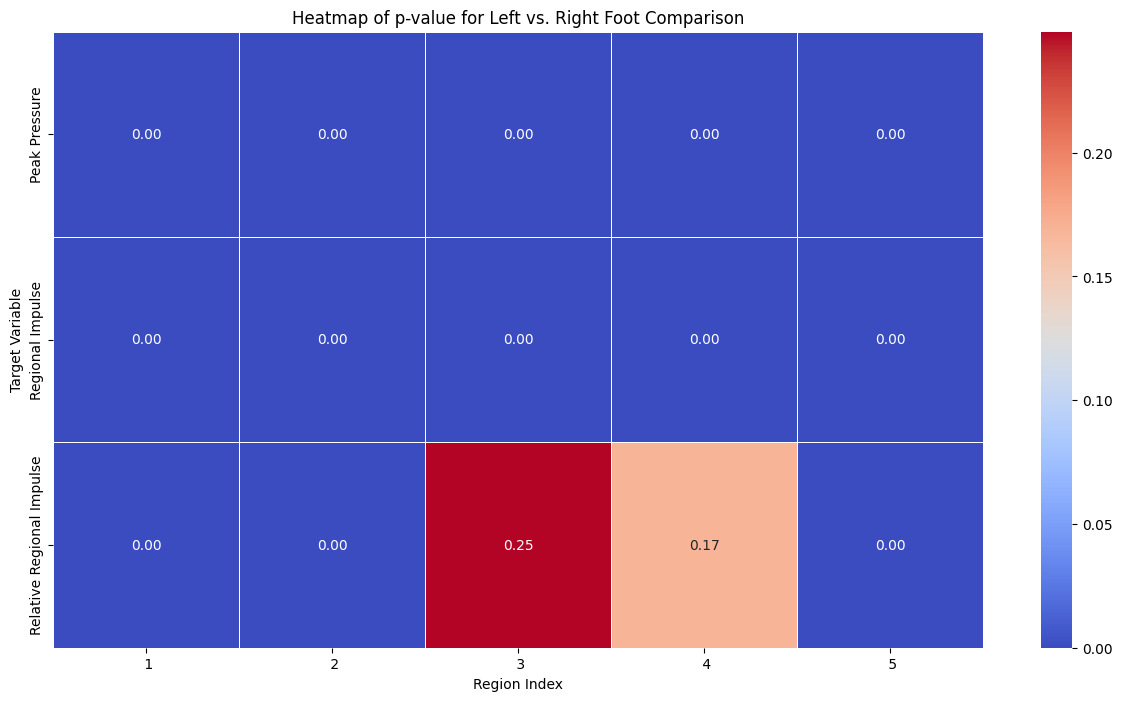

In [38]:
# Pivot the data to get a 5x3 matrix for heatmap plotting
p_value_matrix = test_df.pivot(index="Target Variable", columns="region index", values="p-value")

# Create a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(p_value_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of p-value for Left vs. Right Foot Comparison")
plt.xlabel("Region Index")
plt.ylabel("Target Variable")
plt.show()

# Oren

In [4]:
files_path = 'data/stroke_six/'
section_file_list = os.listdir(files_path)
left_section_data_dict = {}
right_section_data_dict = {}
other_dict = {}

for section in section_file_list:
    region = section.replace('.csv', '')
    print('processing region ',region)
    section_df = pd.read_csv(files_path + section)
    # section_df['timestamp'] = section_df['timestamp'].apply(lambda x: x[1:-1])
    section_df['timestamp'] = section_df['timestamp'].astype(float)
    length = len(section_df['timestamp'].unique())
    section_data_template = np.zeros((length, 64, 16))
    for i, stamp in enumerate(np.sort(section_df['timestamp'].unique())):
        stamp_df = section_df[section_df['timestamp'] == stamp].reset_index(drop = True)
        for _, row in stamp_df.iterrows():
            row_idx = row['row']
            col_idx = row['col']
            pressure = row['pressure']
            section_data_template[i, int(row_idx), int(col_idx)] = pressure
    if 'left' in region:
        left_section_data_dict[region] = section_data_template
    elif 'right' in region:
        right_section_data_dict[region] = section_data_template
    else:
        other_dict[region] = section_data_template

processing region  forelat_left
processing region  forelat_right
processing region  foremed_left
processing region  foremed_right
processing region  hindlat_left
processing region  hindlat_right
processing region  hindmed_left
processing region  hindmed_right
processing region  midlat_left
processing region  midlat_right
processing region  midmed_left
processing region  midmed_right


In [6]:
import json
def save_json(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, indent=4)    

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

In [24]:
resample_frames = 500

final_output_df = pd.DataFrame()
start_idx = range(0, left_section_data_dict['forelat_left'].shape[0], resample_frames)

for i in tqdm(start_idx):
    if i == 0:
        continue
    if i == start_idx[-1]:
        continue
    resample_dict = {}
    for region in left_section_data_dict:
        insole_data = left_section_data_dict[region]
        start_idx = range(0, insole_data.shape[0], resample_frames)


            
        input_insole = insole_data[i:i+resample_frames]
        resample_dict[region] = input_insole

    output_df = calculate_relative_region_impulse(resample_dict)
    output_df['Peak Pressure'] = output_df['Region'].apply(lambda x: calculate_peak_impulse(resample_dict[x]))
    output_df = output_df[['Region','Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']]
    output_df['sample_idx'] = i
    output_df['foot'] = 'left'

    final_output_df = pd.concat([final_output_df,output_df],axis = 0, ignore_index=True)

for i in tqdm(start_idx):
    if i == 0:
        continue
    if i == start_idx[-1]:
        continue
    resample_dict = {}
    for region in right_section_data_dict:
        insole_data = right_section_data_dict[region]
        start_idx = range(0, insole_data.shape[0], resample_frames)


            
        input_insole = insole_data[i:i+resample_frames]
        resample_dict[region] = input_insole

    output_df = calculate_relative_region_impulse(resample_dict)
    output_df['Peak Pressure'] = output_df['Region'].apply(lambda x: calculate_peak_impulse(resample_dict[x]))
    output_df = output_df[['Region','Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']]
    output_df['sample_idx'] = i
    output_df['foot'] = 'right'

    final_output_df = pd.concat([final_output_df,output_df],axis = 0, ignore_index=True)

100%|██████████| 12/12 [00:00<00:00, 109.61it/s]


In [25]:
final_output_df

,Region,Peak Pressure,Regional Impulse,Relative Regional Impulse,sample_idx,foot
0,forelat_left,1641.608040,4690.156382,0.146638,500,left
1,foremed_left,1289.370998,3933.469831,0.122980,500,left
2,hindlat_left,2317.634992,7643.370980,0.238970,500,left
3,hindmed_left,2783.173252,8953.514894,0.279931,500,left
4,midlat_left,2296.205128,4029.046154,0.125968,500,left
...,...,...,...,...,...,...
115,foremed_right,2314.579464,8605.560863,0.155135,5000,right
116,hindlat_right,2903.723193,8146.213525,0.146854,5000,right
117,hindmed_right,3252.611219,8816.640567,0.158940,5000,right
118,midlat_right,3549.125614,13066.315789,0.235550,5000,right


In [35]:
final_output_df['Region'] = final_output_df['Region'].apply(lambda x: x.split('_')[0])

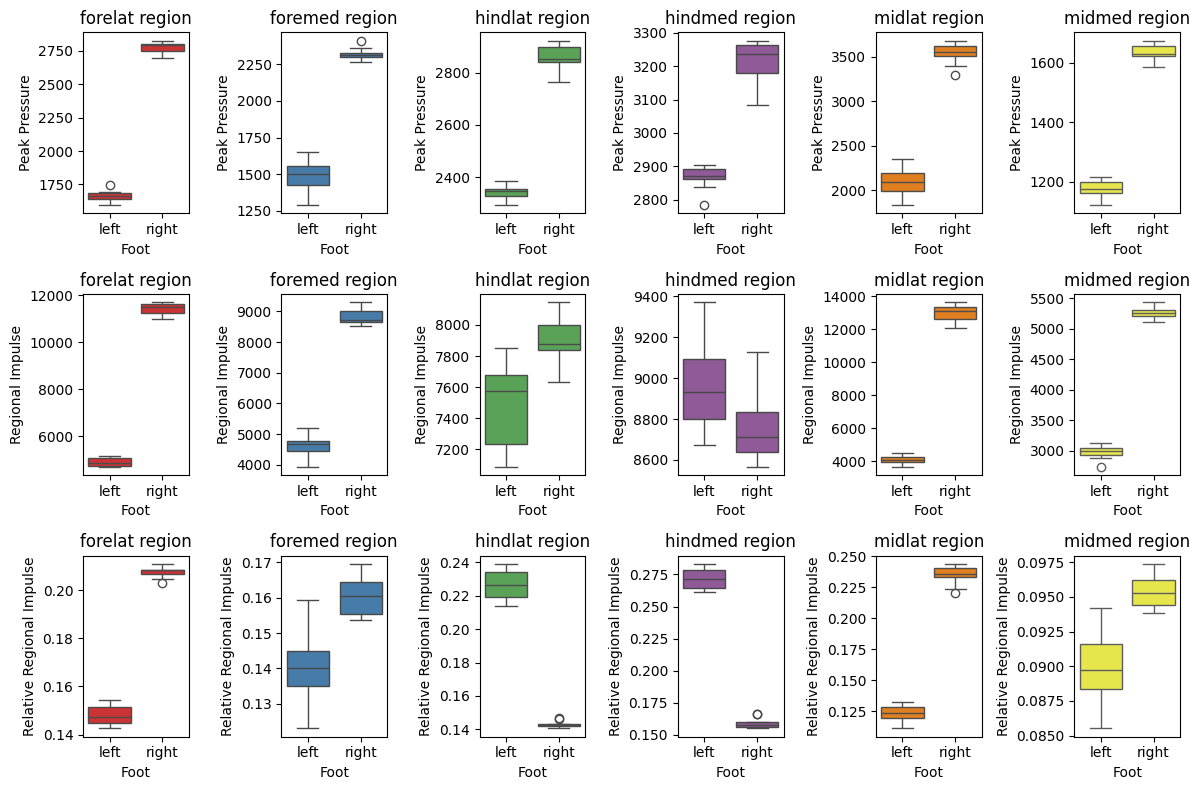

In [38]:
df = final_output_df
variables = ["Peak Pressure", "Regional Impulse", "Relative Regional Impulse"]
region_indices = sorted(df["Region"].dropna().unique())
palette = dict(zip(range(6), sns.color_palette("Set1", len(region_indices))))  # Using 'viridis' colormap


# Create subplots with 3 rows (variables) and 5 columns (region indices)
fig, axes = plt.subplots(len(variables), len(region_indices), figsize=(12, 8))

# Generate box plots
for j, var in enumerate(variables):
    for i, region in enumerate(region_indices):
        ax = axes[j, i]
        sns.boxplot(
            data=df[df["Region"] == region],
            x="foot",
            y=var,
            ax=ax,
            color=palette[i]
        )
        ax.set_title(f"{region} region")
        ax.set_xlabel("Foot")
        ax.set_ylabel(var)

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [34]:
region_indices

['forelat_left',
 'forelat_right',
 'foremed_left',
 'foremed_right',
 'hindlat_left',
 'hindlat_right',
 'hindmed_left',
 'hindmed_right',
 'midlat_left',
 'midlat_right',
 'midmed_left',
 'midmed_right']

In [31]:
region_indices

['forelat_left',
 'forelat_right',
 'foremed_left',
 'foremed_right',
 'hindlat_left',
 'hindlat_right',
 'hindmed_left',
 'hindmed_right',
 'midlat_left',
 'midlat_right',
 'midmed_left',
 'midmed_right']